In [50]:
import pandas as pd
import numpy as np


from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


In [38]:
df = pd.read_parquet("df_preprocessed.parquet")

train_cycles = ["A1", "B1", "B3"]
val_cycle    = "A2"
test_cycle   = "B2"

df_train = df[df["cycle_id"].isin(train_cycles)].copy()
df_val   = df[df["cycle_id"] == val_cycle].copy()
df_test  = df[df["cycle_id"] == test_cycle].copy()

feature_cols_all = [
    c for c in df_train.columns
    if c not in ["pump_id", "cycle_id", "end_time", "label"]
]

X_train = df_train[feature_cols_all]
X_val   = df_val[feature_cols_all]
X_test  = df_test[feature_cols_all]

y_train = df_train["label"]
y_val   = df_val["label"]
y_test  = df_test["label"]




In [39]:
from sklearn.impute import SimpleImputer

# LR-specific feature matrix

imputer = SimpleImputer(strategy="median")

X_train_lr = imputer.fit_transform(X_train)
X_val_lr = imputer.transform(X_val)
X_test_lr = imputer.transform(X_test)

y_train_lr = y_train.copy()
y_val_lr   = y_val.copy()
y_test_lr  = y_test.copy()



lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=500,
        class_weight="balanced"   
    ))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

#gridsearch run
grid_lr = GridSearchCV(
    lr_pipe,
    param_grid_lr,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid_lr.fit(X_train_lr, y_train_lr)

print("Best LR params:", grid_lr.best_params_)

# evaluation
print("Validation performance:")
print(classification_report(y_val_lr, grid_lr.predict(X_val_lr)))
print("ROC-AUC:", roc_auc_score(y_val_lr, grid_lr.predict_proba(X_val_lr)[:,1]))


Best LR params: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Validation performance:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      3908
           1       0.18      1.00      0.31       168

    accuracy                           0.82      4076
   macro avg       0.59      0.90      0.60      4076
weighted avg       0.97      0.82      0.87      4076

ROC-AUC: 0.8927429083199299



Permutation Importance (sorted):
                     feature  importance_mean  importance_std
8                 output_std         0.264064        0.011546
4              torque_median         0.128051        0.012373
7                output_mean         0.121203        0.008576
5                 torque_std         0.086901        0.008717
19                   dm1_std         0.070625        0.011040
15           flow_total_mean         0.055246        0.005091
3   active_pressure_fraction         0.050108        0.005645
16           tank_level_mean         0.044780        0.004077
1                delta_p_std         0.038654        0.004792
14         flow_primary_mean         0.031937        0.009340
18                  dm1_mean         0.021529        0.005793
20                  dm2_mean         0.021327        0.004916
26              pc3_fraction         0.014507        0.002160
11               suction_std         0.012142        0.003865
10              suction_mean        

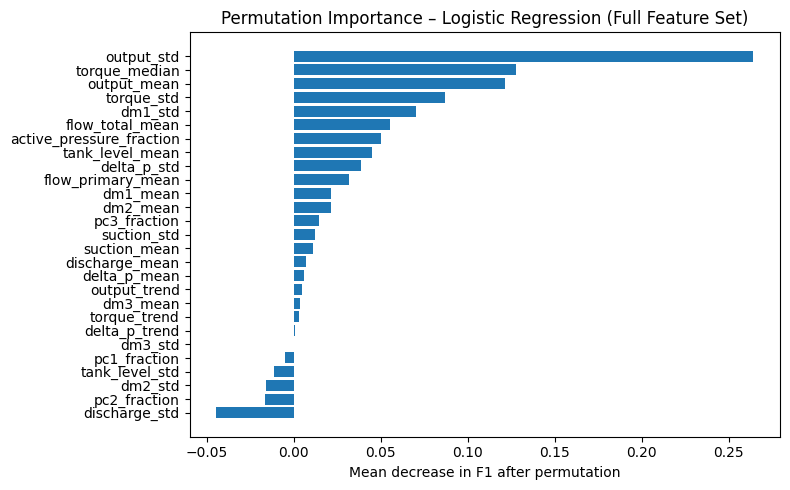

In [52]:
#permutation importance of log res (reduced):


# use best estimator
best_lr_model = grid_lr.best_estimator_

# Compute permutation importance on val set
perm_result = permutation_importance(
    best_lr_model,
    X_val_lr,          
    y_val_lr,
    n_repeats=50,
    scoring="f1",
    random_state=42
)

#  importance table
importances_lr = pd.DataFrame({
    "feature": feature_cols_all,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
}).sort_values("importance_mean", ascending=False)

print("\nPermutation Importance (sorted):")
print(importances_lr)

# plot
plt.figure(figsize=(8, 5))
plt.barh(importances_lr["feature"], importances_lr["importance_mean"])
plt.xlabel("Mean decrease in F1 after permutation")
plt.title("Permutation Importance – Logistic Regression (Full Feature Set)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()





In [44]:
#Random forest

from sklearn.impute import SimpleImputer

torque_imputer = SimpleImputer(strategy="median")

X_train_sup = torque_imputer.fit_transform(X_train)
X_val_sup   = torque_imputer.transform(X_val)
X_test_sup  = torque_imputer.transform(X_test)

# rf
rf_pipe = Pipeline([
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"   
    ))
])

# optuna search space
rf_param_distributions = {
    "clf__n_estimators": optuna.distributions.IntDistribution(200, 600),
    "clf__max_depth": optuna.distributions.IntDistribution(3, 20),
    "clf__min_samples_split": optuna.distributions.IntDistribution(2, 10),
    "clf__min_samples_leaf": optuna.distributions.IntDistribution(1, 4),
    "clf__max_features": optuna.distributions.CategoricalDistribution(["sqrt", "log2"]),
}
#run optuna
rf_search = OptunaSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_distributions,
    n_trials=40,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit
rf_search.fit(X_train_sup, y_train)

print("Best RF Params:", rf_search.best_params_)

# Evaluation
rf_pred_val = rf_search.predict(X_val_sup)
print("\nValidation Performance:")
print(classification_report(y_val, rf_pred_val))

if hasattr(rf_search, "predict_proba"):
    print("Validation ROC-AUC:",
          roc_auc_score(y_val, rf_search.predict_proba(X_val)[:,1]))


/var/folders/4d/4htwx0b53_s1x9dcz_dvsbnw0000gn/T/ipykernel_89374/710107219.py:33: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rf_search = OptunaSearchCV(
[I 2025-11-30 22:35:38,777] A new study created in memory with name: no-name-953c4066-f22f-46eb-8585-caf08ede8c52
[I 2025-11-30 22:35:46,426] Trial 1 finished with value: 0.36561772021952854 and parameters: {'clf__n_estimators': 211, 'clf__max_depth': 19, 'clf__min_samples_split': 6, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt'}. Best is trial 1 with value: 0.36561772021952854.
[I 2025-11-30 22:35:47,292] Trial 0 finished with value: 0.35732658654859795 and parameters: {'clf__n_estimators': 231, 'clf__max_depth': 16, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 3, 'clf__max_features': 'log2'}. Best is trial 1 with value: 0.36561772021952854.
[I 2025-11-30 22:35:50,351] Trial 2 finished with value: 0.36322629156334724 and parameters: {'clf__

Best RF Params: {'clf__n_estimators': 454, 'clf__max_depth': 10, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 3, 'clf__max_features': 'log2'}

Validation Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3908
           1       0.00      0.00      0.00       168

    accuracy                           0.94      4076
   macro avg       0.48      0.49      0.48      4076
weighted avg       0.92      0.94      0.93      4076

Validation ROC-AUC: 0.7710587561534337


/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [47]:
#XGBoost

from sklearn.impute import SimpleImputer

torque_imputer = SimpleImputer(strategy="median")

X_train_sup = torque_imputer.fit_transform(X_train)
X_val_sup   = torque_imputer.transform(X_val)
X_test_sup  = torque_imputer.transform(X_test)



# Calculate imbalance ratio
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos
print("scale_pos_weight =", scale_pos_weight)

# Pipeline xgb with imbalance ratio:


pipe_xgb = Pipeline([
    ("clf", XGBClassifier(
        tree_method="hist",
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=scale_pos_weight   
    ))
])

# optuna search space
def objective(trial):

    params = {
        "clf__n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "clf__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.10),
        "clf__max_depth": trial.suggest_int("max_depth", 2, 10),
        "clf__subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "clf__colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "clf__min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
    }

    model = pipe_xgb.set_params(**params)

    model.fit(X_train_sup, y_train)

    preds = model.predict(X_val_sup)
    return f1_score(y_val, preds, zero_division=0)


#optuna run
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

best_params = study.best_params
print("Best XGB Params:", best_params)

# fit
pipe_xgb_best = pipe_xgb.set_params(**{
    f"clf__{k}": v for k, v in best_params.items()
})

pipe_xgb_best.fit(X_train_sup, y_train)

# plot
xgb_preds = pipe_xgb_best.predict(X_val_sup)

print("\nValidation F1:", f1_score(y_val, xgb_preds))
print("Validation ROC-AUC:",
      roc_auc_score(y_val, pipe_xgb_best.predict_proba(X_val)[:,1]))


[I 2025-11-30 22:37:22,299] A new study created in memory with name: no-name-8cea988d-8d33-4b16-aff2-041775978e15


scale_pos_weight = 24.94047619047619


[I 2025-11-30 22:37:22,521] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 447, 'learning_rate': 0.07514328379687678, 'max_depth': 2, 'subsample': 0.9809175345632706, 'colsample_bytree': 0.9800652481454415, 'min_child_weight': 2}. Best is trial 0 with value: 0.0.
[I 2025-11-30 22:37:22,806] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 582, 'learning_rate': 0.016074655034565313, 'max_depth': 2, 'subsample': 0.8684626983380433, 'colsample_bytree': 0.7268777944668452, 'min_child_weight': 3}. Best is trial 0 with value: 0.0.
[I 2025-11-30 22:37:23,065] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 427, 'learning_rate': 0.0877882569831927, 'max_depth': 7, 'subsample': 0.7055878393935686, 'colsample_bytree': 0.6102819917480422, 'min_child_weight': 1}. Best is trial 0 with value: 0.0.
[I 2025-11-30 22:37:23,275] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 317, 'learning_rate': 0.05135722412737702, 'max_depth': 6

Best XGB Params: {'n_estimators': 447, 'learning_rate': 0.07514328379687678, 'max_depth': 2, 'subsample': 0.9809175345632706, 'colsample_bytree': 0.9800652481454415, 'min_child_weight': 2}

Validation F1: 0.0
Validation ROC-AUC: 0.8245707827655115


In [48]:
#validation scores

print("===== LOGISTIC REGRESSION — Validation =====")
val_pred_lr = grid_lr.predict(X_val_lr)
val_prob_lr = grid_lr.predict_proba(X_val_lr)[:, 1]

print(classification_report(y_val, val_pred_lr))
print("ROC-AUC:", roc_auc_score(y_val, val_prob_lr))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_lr))


print("\n===== RANDOM FOREST — Validation =====")
val_pred_rf = rf_search.predict(X_val_sup)
val_prob_rf = rf_search.predict_proba(X_val_sup)[:, 1]

print(classification_report(y_val, val_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, val_prob_rf))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_rf))


print("\n===== XGBOOST — Validation =====")
val_pred_xgb = pipe_xgb_best.predict(X_val_sup)
val_prob_xgb = pipe_xgb_best.predict_proba(X_val_sup)[:, 1]

print(classification_report(y_val, val_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_val, val_prob_xgb))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_xgb))


===== LOGISTIC REGRESSION — Validation =====
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      3908
           1       0.18      1.00      0.31       168

    accuracy                           0.82      4076
   macro avg       0.59      0.90      0.60      4076
weighted avg       0.97      0.82      0.87      4076

ROC-AUC: 0.8927429083199299
Confusion matrix:
 [[3164  744]
 [   0  168]]

===== RANDOM FOREST — Validation =====
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3908
           1       0.00      0.00      0.00       168

    accuracy                           0.94      4076
   macro avg       0.48      0.49      0.48      4076
weighted avg       0.92      0.94      0.93      4076

ROC-AUC: 0.7710587561534337
Confusion matrix:
 [[3835   73]
 [ 168    0]]

===== XGBOOST — Validation =====
              precision    recall  f1-score   support

           0       0.96 

In [49]:
#test scores: 

print("===== LOGISTIC REGRESSION — Test =====")
test_pred_lr = grid_lr.predict(X_test_lr)
test_prob_lr = grid_lr.predict_proba(X_test_lr)[:, 1]

print(classification_report(y_test, test_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, test_prob_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred_lr))


print("\n===== RANDOM FOREST — Test =====")
test_pred_rf = rf_search.predict(X_test_sup)
test_prob_rf = rf_search.predict_proba(X_test_sup)[:, 1]

print(classification_report(y_test, test_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, test_prob_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred_rf))


print("\n===== XGBOOST — Test =====")
test_pred_xgb = pipe_xgb_best.predict(X_test_sup)
test_prob_xgb = pipe_xgb_best.predict_proba(X_test_sup)[:, 1]

print(classification_report(y_test, test_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, test_prob_xgb))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred_xgb))


===== LOGISTIC REGRESSION — Test =====
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3384
           1       0.00      0.00      0.00       168

    accuracy                           0.93      3552
   macro avg       0.48      0.49      0.48      3552
weighted avg       0.91      0.93      0.92      3552

ROC-AUC: 0.5677681385793087
Confusion matrix:
 [[3295   89]
 [ 168    0]]

===== RANDOM FOREST — Test =====
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3384
           1       0.00      0.00      0.00       168

    accuracy                           0.95      3552
   macro avg       0.48      0.50      0.49      3552
weighted avg       0.91      0.95      0.93      3552

ROC-AUC: 0.1573300123832039
Confusion matrix:
 [[3364   20]
 [ 168    0]]

===== XGBOOST — Test =====
              precision    recall  f1-score   support

           0       0.95      0.98      0.9